In [1]:
# Load the lightning model from checkpoint

import pytorch_lightning as pl
import torch
import numpy as np
from torch.utils.data import DataLoader  # Import DataLoader
from src.failure_model import ToxicClassifier
from src.datasets import PromptOnlyDataset, PropDataset

cal_prompts = PromptOnlyDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl")

cal_props = PropDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl", score_name="toxicity", threshold=0.5)

# cal_prompts.data = cal_prompts.data[-100:]
# cal_props.data = cal_props.data[-100:]

# Examine the model weights in the checkpoint before loading
model = ToxicClassifier.load_from_checkpoint("saved/Prop_rtp_500_ModernBERT_L1/lightning_logs/version_11/checkpoints/epoch=4-step=495.ckpt")

taus = torch.tensor(np.logspace(-3, 0, 200))
# Get the index closest to 0.1
idx = (taus - 0.1).abs().argmin()
model.set_taus(taus)
model.set_min_p_for_q_tau(1e-20)
model.set_threshold_p_for_q_tau(1e-4)
model.eval()

trainer = pl.Trainer()

# Create a custom DataLoader for prediction with a batch size of 1500
predict_dataloader = DataLoader(cal_prompts, batch_size=1500, shuffle=False)

# Use the trainer and predict on cal_prompts using the custom DataLoader
pred = trainer.predict(model, dataloaders=predict_dataloader)


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency

Predicting: |          | 0/? [00:00<?, ?it/s]

In [2]:
pred = {"proba": torch.cat([p["proba"] for p in pred], dim=0),}
if "tau" in model.hparams:
    pred["tau"] = torch.tensor([p["tau"] for p in pred], dtype=torch.float32)

/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/scipy/stats/_discrete_distns.py:562: RuntimeWarning: divide by zero encountered in log1p
  vals = ceil(log1p(-q) / log1p(-p))
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/scipy/stats/_discrete_distns.py:552: RuntimeWarning: divide by zero encountered in log1p
  return -expm1(log1p(-p)*k)


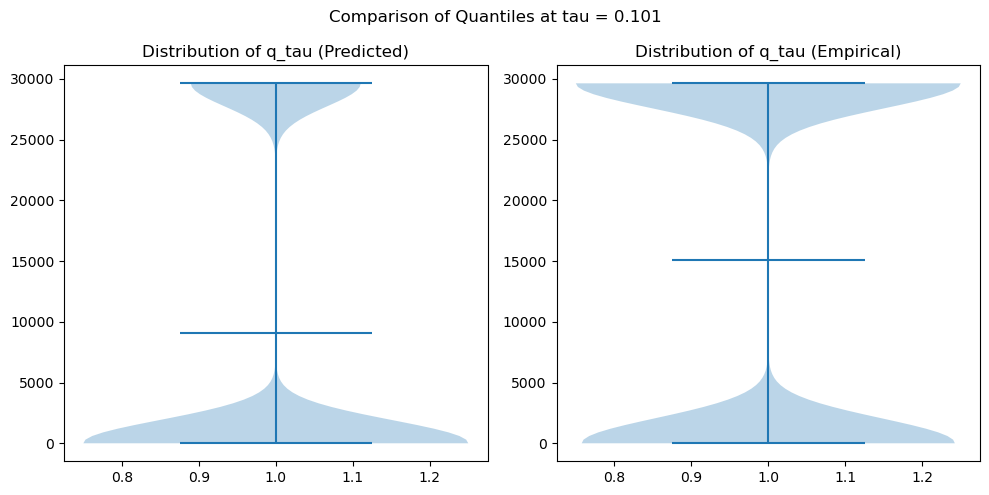

In [3]:
from matplotlib import pyplot as plt
# from scipy.stats.geom import ppf
import scipy

quant_pred = [scipy.stats.geom.ppf(taus[idx], max(item.item() if item.item() > 1e-3 else 1e-20, 36e-7)) for item in pred['proba']]

quant_emp = [scipy.stats.geom.ppf(taus[idx], max(item[1][0], 36e-7)) for item in cal_props]

# Plot the distributions of quant_pred and quant_emp with a violin plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot(quant_pred, showmeans=True)
plt.title(f"Distribution of q_tau (Predicted)")
plt.subplot(1, 2, 2)
plt.violinplot(quant_emp, showmeans=True)
plt.title(f"Distribution of q_tau (Empirical)")
plt.suptitle(f"Comparison of Quantiles at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

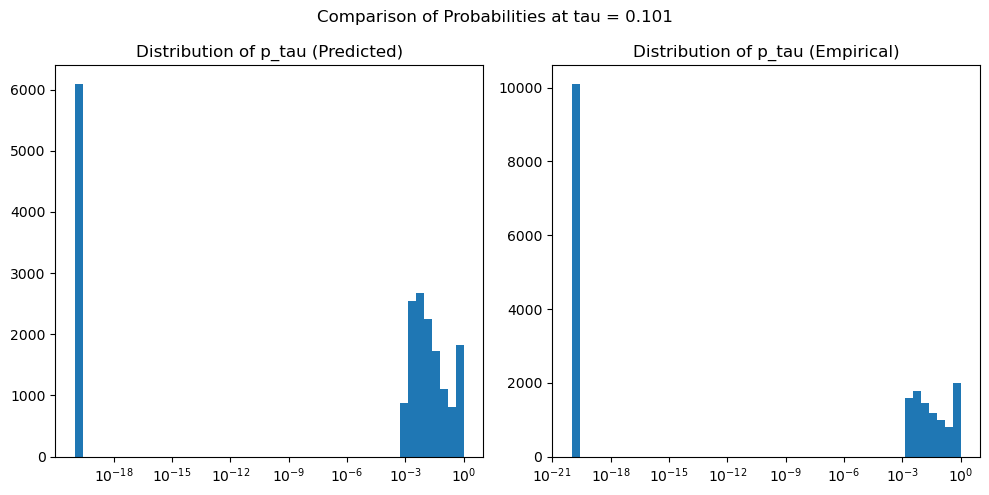

In [4]:
# Now plot the distribution of the probabilities themselves in log scale in x
proba_pred = np.array([item.item() for item in pred['proba']])
proba_pred = np.clip(proba_pred, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
proba_pred[proba_pred < 1e-3] = 1e-20  # Set small values to a minimum threshold
proba_emp = np.array([item[1][0] for item in cal_props])
proba_emp = np.clip(proba_emp, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
# Create logarithmically spaced bins based on the range of the data
bins_pred = np.logspace(np.log10(proba_pred.min()), np.log10(proba_pred.max()), 50)
bins_emp = np.logspace(np.log10(proba_emp.min()), np.log10(proba_emp.max()), 50)

plt.figure(figsize=(10, 5))

# Plot predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(proba_pred, bins=bins_pred)
plt.xscale('log')
plt.title("Distribution of p_tau (Predicted)")

# Plot empirical probabilities
plt.subplot(1, 2, 2)
plt.hist(proba_emp, bins=bins_emp)
plt.xscale('log')
plt.title("Distribution of p_tau (Empirical)")

plt.suptitle(f"Comparison of Probabilities at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

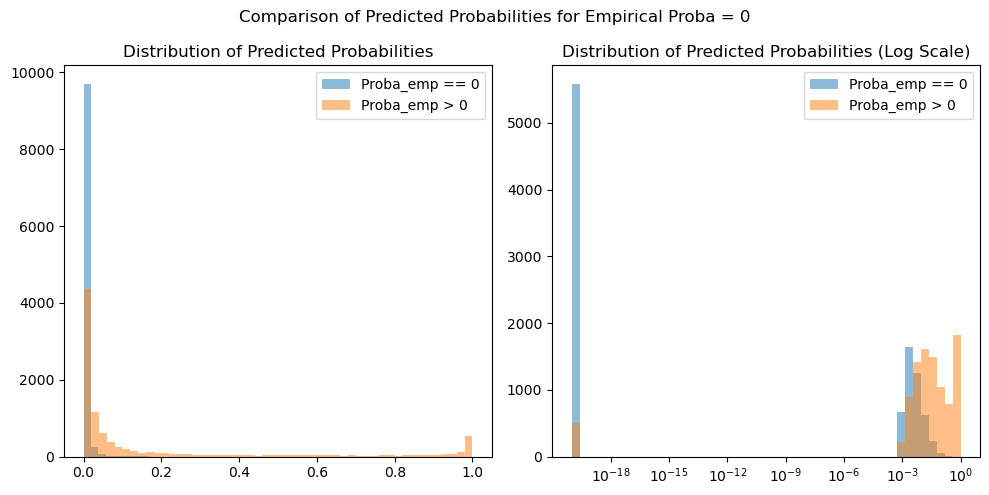

In [5]:
# Check if the samples for which proba_emp == 0 are seperable from the rest based on a threshold on the predicted probabilities
# Get the indices of the samples where proba_emp == 0
zero_indices = np.where(proba_emp < 1e-10)[0]
# Get the predicted probabilities for these samples
zero_pred_probs = proba_pred[zero_indices]
# Get the predicted probabilities for the rest of the samples
non_zero_indices = np.where(proba_emp > 1e-10)[0]
non_zero_pred_probs = proba_pred[non_zero_indices]
# Plot the distributions of the predicted probabilities for both groups
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp > 0')
plt.legend()
plt.title("Distribution of Predicted Probabilities")
# Now in log scale
plt.subplot(1, 2, 2)
plt.hist(zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp > 0')
plt.xscale('log')
plt.legend()
plt.title("Distribution of Predicted Probabilities (Log Scale)")
plt.suptitle(f"Comparison of Predicted Probabilities for Empirical Proba = 0")
plt.tight_layout()

In [6]:
# Create generation and rating backends
from src.rating.detoxify import DetoxifyRater
from src import utils
from src.generation.vanilla_model_hf import VanillaGeneratorHF
from src.survival_runner import (
    SurvivalRunner,
    SurvivalResult,
    default_toxicity_func,
    default_text_prep_func,
)

# Create the parameter dictionary for the rating backend.
rater_params = {
    "model_type": "original",
    "amp": True,
}

# Get the Hugging Face key.
hf_key = utils.api_key_from_file("HF_KEY.txt")

# Create the parameter dictionary for the generation backend.
generator_params = {
    "model_name": "meta-llama/Llama-3.2-3B",
    "hub_token": hf_key,
    "max_input_tokens": 40,
    "max_output_tokens": 30,
    "torch_dtype": torch.bfloat16,
    # If you need to specify the attention implementation, uncomment the line below.
    # "attn_implementation": "flash_attention_2",
}

In [7]:
# Force reimport
import importlib
import src.conformal
importlib.reload(src.conformal)
from src.conformal import conformalize

trainer = pl.Trainer()
target_taus = torch.tensor([0.1])
canidate_taus = torch.tensor(np.logspace(-9, -1, 200))

tau_hat, max_est, q_hat = conformalize(trainer=trainer, model=model, target_taus=target_taus, canidate_taus=canidate_taus, X=cal_prompts, generator_params=generator_params, rater_params=rater_params, 
                              budget_per_sample=200, share_budget=True, min_sample_size=0.5, text_prep_func=lambda gen: gen.prompt + gen.output)

/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dahen/miniconda3/envs/llm-survival/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

(19888, 200)


TypeError: LlamaForCausalLM.__init__() got an unexpected keyword argument 'max_batch_size'

In [ ]:
print(tau_hat)
print(max_est)
# Print the average prediction for tau=tau_hat
idx_tau_hat = (taus - tau_hat).abs().argmin()
print("Average prediction for tau=tau_hat:", torch.mean(torch.minimum(torch.stack([item['tau'][idx_tau_hat] for item in pred]), torch.tensor(max_est))))
print("Average prediction for tau=0.1:", torch.mean(torch.stack([item['tau'][idx] for item in pred])))

# Plot the distribution of [item['tau'][idx_tau_hat].item() for item in pred]
plt.hist(q_hat, bins=50)
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()